# PRIMO - The P&A Project Optimizer
## Workflow Demo 

This notebook contains a demo of PRIMO - The P&A Project Optimizer. Utilizing the workflow in the image below, PRIMO reads in  input data on marginal wells and their characteristics and analyzes it with respect to **USER-DEFINED PRIORITIES AND PREFERENCES** to provide recommendations on the design of impactful and efficient P&A projects. 

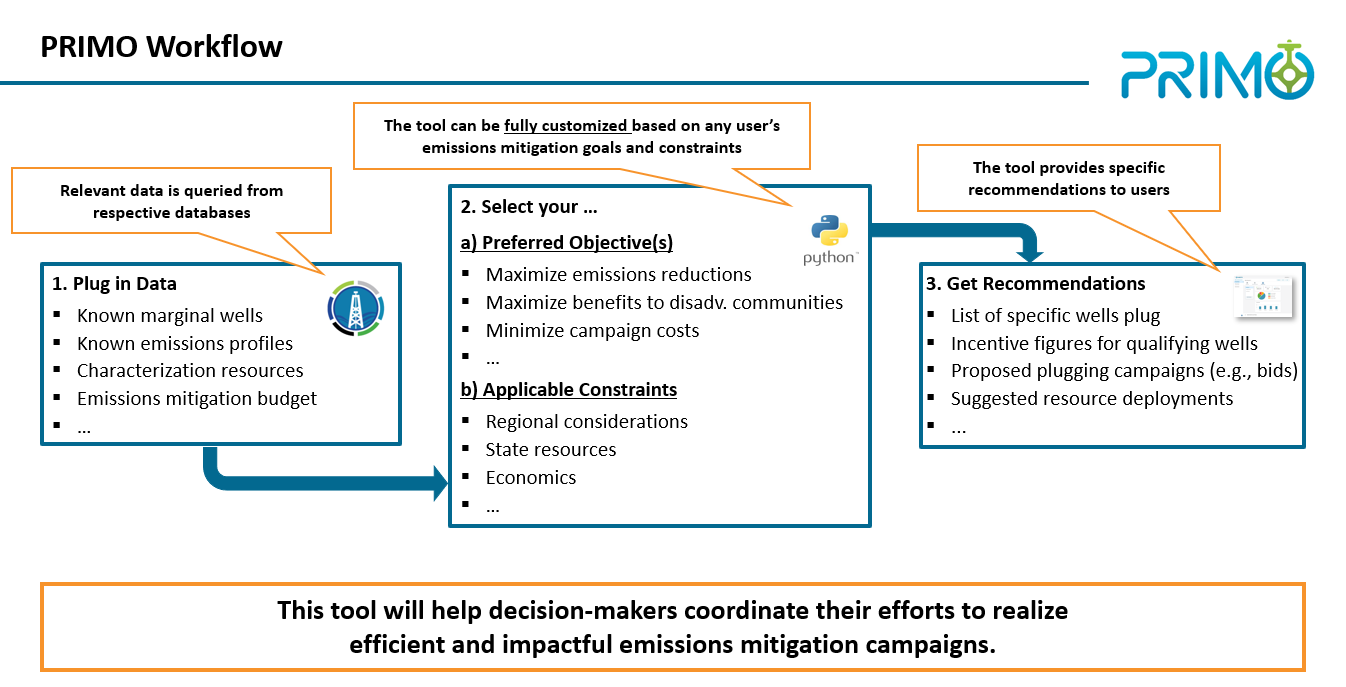

## Priority & Weight Selection Guidelines

Please use the following guidelines when selecting your priorities and their respective weights:
- Use the checkboxes to select preferred priorities and the respective sliders to specify the weight of these 
- Some priorities may also allow for the specification of sub-priorities (e.g., the sensitive receptors priority involves 8 sub-priorities: schools, hospitals, buildings, etc.).
- Use the checkbox to select a sub-priority and the corresponding slider to specify the weight of the sub-priority
- A sub-priority can only be selected if the corresponding "parent" priority has been selected
- The sum of all priorities needs to be 100
- The sum of all sub-priorities within each priority needs to be 100
- If you wish to change the weights after confirming them or getting an error, please re-run this cell in order to get a fresh start

## Using Config File to Provide Inputs

PRIMO utilizes a .json config file to define priority metrics, efficiency metrics, and constraints. Users can also specify default paths for input data files and output files. The current demo includes a config file - config_example.json. For detailed guidance on the purpose, construction, and modification of the config file, please refer to the documentation [Config File](https://primo.readthedocs.io/en/.html). (This link needs to be updated once the documentation is connected to readthedocs)

## Notice

This demo uses randomized data on a 2-d grid (x and y coordinates). Here, the x-coordinate represents the latitude, and the y-coordinate represents the longitude of a well. The demo results are accordingly visualized in scatter plots. 

PRIMO is designed to process geospatial data containing latitude and longitude information such as shapefiles and also queries data from external sources such as U.S. Census. PRIMO also has utilities available to plot visualizations using maps instead of 2-d grids. 

This notebook is primarily meant to showcase the workflow and functionality of PRIMO. PRIMO is under active development: please reach out to primo@netl.doe.gov for questions, comments, feedback or feature requests.

In [1]:
# Standard libs
import logging

# Imports from installed libraries
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PRIMO imports
from primo.data_parser import (
    EfficiencyMetrics,
    ImpactMetrics,
    WellDataColumnNames
)
from primo.data_parser.well_data import WellData
from primo.opt_model.result_parser import (
    EfficiencyCalculator,
    export_data_to_excel
)
from primo.opt_model.model_options import OptModelInputs
from primo.utils import setup_logger
from primo.utils.config_utils import UserSelection
from primo.utils.map_utils import get_cluster_colors
from primo.utils.override_utils import OverrideCampaign


# Setup logger
setup_logger()
pd.set_option('display.precision',2)

## Impact Metric Selection

In [2]:
# Define impact metrics by creating an instance of ImpactMetrics class
im_metrics = ImpactMetrics()

# Specify weights
im_metrics.set_weight(
    primary_metrics={
        "ch4_emissions": 35,
        "sensitive_receptors": 20,
        "ann_production_volume": 20,
        "well_age": 15,
        "well_count": 10,
    },
    submetrics={
        "ch4_emissions": {
            "leak": 40,
            "compliance": 30,
            "violation": 20,
            "incident": 10,
        },
        "sensitive_receptors": {
            "schools": 50,
            "hospitals": 50,
        },
        "ann_production_volume": {
            "ann_gas_production": 50,
            "ann_oil_production": 50,
        }
    }
)

# Check if the weights are valid or not
im_metrics.check_validity()

print(im_metrics)

                                                Metric Name  Metric weight
ch4_emissions                   Methane Emissions (Proxies)             35
dac_impact                   Disadvantaged Community Impact              0
sensitive_receptors                     Sensitive Receptors             20
ann_production_volume              Annual Production Volume             20
five_year_production_volume     Five-year Production Volume              0
well_age                                           Well Age             15
well_count                                 Owner Well Count             10
other_emissions                             Other Emissions              0
well_integrity               Well Integrity Issues [Yes/No]              0
environment                                     Environment              0
                                                      Total            100


Primary metric Methane Emissions (Proxies), with weight 35, has submetrics:
                 Subme

In [3]:
# (OPTIONAL) Metrics/submetrics that are not required can be deleted.
# This is an optional step. As long as their weight is set to zero, metric/submetrics
# that are not needed can still remain in the im_metrics object.
im_metrics.delete_metric("dac_impact")  # Deletes the metric as well submetrics "fed_dac" and "state_dac"
im_metrics.delete_metric("other_emissions")
im_metrics.delete_metric("five_year_production_volume")
im_metrics.delete_metric("well_integrity")
im_metrics.delete_metric("environment")

# Submetrics can also be deleted in a similar manner
im_metrics.delete_submetric("buildings_near")
im_metrics.delete_submetric("buildings_far")

print(im_metrics)

                                       Metric Name  Metric weight
ch4_emissions          Methane Emissions (Proxies)             35
sensitive_receptors            Sensitive Receptors             20
ann_production_volume     Annual Production Volume             20
well_age                                  Well Age             15
well_count                        Owner Well Count             10
                                             Total            100


Primary metric Methane Emissions (Proxies), with weight 35, has submetrics:
                 Submetric Name  Submetric weight
leak              Leak [Yes/No]                40
compliance  Compliance [Yes/No]                30
violation    Violation [Yes/No]                20
incident      Incident [Yes/No]                10
                          Total               100


Primary metric Sensitive Receptors, with weight 20, has submetrics:
          Submetric Name  Submetric weight
hospitals      Hospitals                50
scho

In [4]:
# # Alternatively, use the widget to set weights
# im_metrics_widget = im_metrics.build_widget()
# im_metrics_widget.display()

In [5]:
# # Update weights from the widget
# im_metrics.set_weight_from_widget(im_metrics_widget)

## Efficiency Metric Selection

In [6]:
# Efficiency metrics can be set in a similar manner
eff_metrics = EfficiencyMetrics()

# Set weights for the metrics
eff_metrics.set_weight(
    primary_metrics={
        "num_wells": 20,
        "num_unique_owners": 30,
        "elevation_delta": 20,
        "age_range": 10,
        "depth_range": 20,
    }
)

# Check validity of the metrics
eff_metrics.check_validity()

# Print the updated metrics
print(eff_metrics)

                                          Metric Name  Metric weight
num_wells                             Number of Wells             20
num_unique_owners             Number of Unique Owners             30
elevation_delta                   Elevation Delta [m]             20
age_range                           Age Range [Years]             10
depth_range                          Depth Range [ft]             20
dist_range                     Distance Range [miles]              0
record_completeness               Record Completeness              0
dist_to_road                 Distance to Road [miles]              0
population_density   Total Population Density [#/km2]              0
                                                Total            100


In [7]:
# # Set weights using the widget
# eff_metrics_widget = eff_metrics.build_widget()
# eff_metrics_widget.display()

In [8]:
# # Update weights from the widget
# eff_metrics.set_weight_from_widget(eff_metrics_widget)

## Read Well Data

In [9]:
# Construct an object to store column names
col_names = WellDataColumnNames(
    well_id="API Well Number",
    latitude="y",
    longitude="x",
    operator_name="Operator Name",
    age="Age [Years]",
    depth="Depth [ft]",

    leak="Leak [Yes/No]",
    compliance="Compliance [Yes/No]",
    violation="Violation [Yes/No]",
    incident="Incident [Yes/No]",

    hospitals="Number of Nearby Hospitals",
    schools="Number of Nearby Schools",

    ann_gas_production="Gas [Mcf/Year]",
    ann_oil_production="Oil [bbl/Year]",
    
    # These are columns used in the efficiency calculation
    elevation_delta="Elevation Delta [m]",
    dist_to_road="Distance to Road [miles]",
)

# Create the well data object
wd = WellData(data="Example_1_data.csv", column_names=col_names, impact_metrics=im_metrics, efficiency_metrics=eff_metrics)

primo: INFO: Reading the well data from the input file.
primo: INFO: Finished reading the well data.
primo: INFO: Beginning to perform preliminary data checks.
primo: INFO: Checking availability and uniqueness of well ids.
primo: INFO: Checking if latitude and longitude information is available for all wells.
primo: INFO: Checking if the operator name is available for all wells.
primo: INFO: Checking if age of all wells is available.
primo: INFO: Checking if depth of all wells is available.
primo: INFO: Completed processing the essential inputs.
primo: INFO: Finished preliminary processing.


### MCW Population Visualization

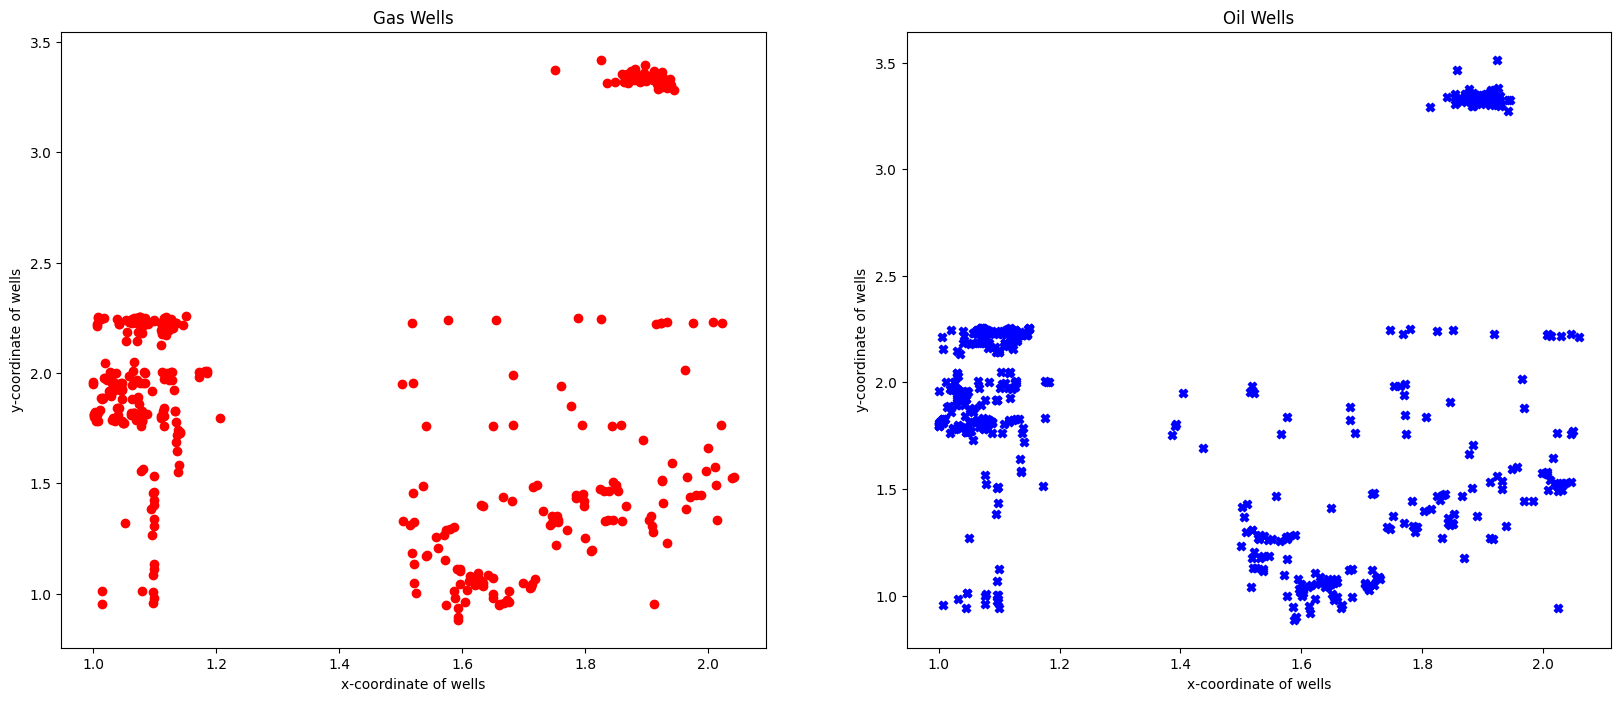

In [10]:
# Split the data data as oil and gas wells
gas_oil_wells = wd.get_gas_oil_wells

# Visualize wells
gas_wells = gas_oil_wells["gas"]   # WellData object
oil_wells = gas_oil_wells["oil"]   # WellData object

well_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.scatter(gas_wells.data["x"], gas_wells.data["y"], c='r', marker="o")
ax1.set_title('Gas Wells')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
ax2.scatter(oil_wells.data["x"], oil_wells.data["y"], c='b', marker="X")
ax2.set_title('Oil Wells')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Capability 1: Prioritizing Wells
The number of wells under consideration is significantly larger than what can be plugged with the budget available. Hence, we prioritize wells as per user-defined priorities to rank the candidate pool of wells.

In [11]:
# Compute priority scores of gas wells
gas_wells.compute_priority_scores()

primo: INFO: Computing scores for metric/submetric well_age/Well Age.
primo: INFO: Computing scores for metric/submetric well_count/Owner Well Count.
primo: INFO: Computing scores for metric/submetric leak/Leak [Yes/No].
primo: INFO: Computing scores for metric/submetric compliance/Compliance [Yes/No].
primo: INFO: Computing scores for metric/submetric violation/Violation [Yes/No].
primo: INFO: Computing scores for metric/submetric incident/Incident [Yes/No].
primo: INFO: Computing scores for metric/submetric hospitals/Hospitals.
primo: INFO: Computing scores for metric/submetric schools/Schools.
primo: INFO: Computing scores for metric/submetric ann_gas_production/Annual Gas Production [in Mcf/Year].
primo: INFO: Computing scores for metric/submetric ann_oil_production/Annual Oil Production [in bbl/Year].
primo: INFO: Computing the total priority score.
primo: INFO: Completed the calculation of priority scores.


In [12]:
# Compute priority scores of oil wells
oil_wells.compute_priority_scores()

primo: INFO: Computing scores for metric/submetric well_age/Well Age.
primo: INFO: Computing scores for metric/submetric well_count/Owner Well Count.
primo: INFO: Computing scores for metric/submetric leak/Leak [Yes/No].
primo: INFO: Computing scores for metric/submetric compliance/Compliance [Yes/No].
primo: INFO: Computing scores for metric/submetric violation/Violation [Yes/No].
primo: INFO: Computing scores for metric/submetric incident/Incident [Yes/No].
primo: INFO: Computing scores for metric/submetric hospitals/Hospitals.
primo: INFO: Computing scores for metric/submetric schools/Schools.
primo: INFO: Computing scores for metric/submetric ann_gas_production/Annual Gas Production [in Mcf/Year].
primo: INFO: Computing scores for metric/submetric ann_oil_production/Annual Oil Production [in bbl/Year].
primo: INFO: Computing the total priority score.
primo: INFO: Completed the calculation of priority scores.


#### Outstanding: Filtering by MERP Volunteers

The MERP is a voluntary program for well owners.

#### Displaying High-Priority Wells

After applying all previously selected priority calculations, we display the highest-scoring wells below.


In [13]:
display(Markdown(
"""
#### Gas Wells by Priority Scores
"""
))

# List of columns to display
cols_to_display = [
    col_names.well_id, col_names.operator_name, col_names.age, col_names.depth]
cols_to_display += [col_name for col_name in gas_wells.data.columns if "Score" in col_name]

top_gas_wells = gas_wells.data.sort_values(by="Priority Score [0-100]", ascending=False)
display(top_gas_wells[cols_to_display].head(10))


#### Gas Wells by Priority Scores


,API Well Number,Operator Name,Age [Years],Depth [ft],Age [Years] Score [0-15],Owner Well-Count Score [0-10],Leak [Yes/No] Score [0-14.0],Compliance [Yes/No] Score [0-10.5],Violation [Yes/No] Score [0-7.0],Incident [Yes/No] Score [0-3.5],Number of Nearby Hospitals Score [0-10.0],Number of Nearby Schools Score [0-10.0],Gas [Mcf/Year] Score [0-10.0],Oil [bbl/Year] Score [0-10.0],Priority Score [0-100]
876,49439,Owner 19,126,1781,12.58,10.00,0.0,10.5,7.0,3.5,10.00,8.0,9.47,9.23,80.28
860,58584,Owner 236,121,12639,12.08,10.00,0.0,10.5,0.0,3.5,10.00,8.0,9.81,10.00,73.89
901,21486,Owner 58,124,10416,12.38,9.05,0.0,10.5,0.0,3.5,10.00,8.0,9.58,9.84,72.85
864,26239,Owner 111,106,12852,10.57,9.05,0.0,10.5,0.0,3.5,10.00,8.0,9.84,10.00,71.46
858,73984,Owner 142,122,3796,12.18,8.19,0.0,10.5,0.0,3.5,10.00,8.0,9.12,9.52,71.01
912,35551,Owner 151,145,6845,14.50,9.05,0.0,10.5,0.0,0.0,10.00,8.0,8.94,9.73,70.71
829,84290,Owner 2,84,2261,8.36,9.05,14.0,10.5,0.0,3.5,10.00,8.0,0.04,6.59,70.03
495,21580,Owner 224,135,5192,13.49,7.41,0.0,10.5,7.0,3.5,0.00,8.0,9.95,10.00,69.85
843,97876,Owner 183,111,10459,11.07,10.00,0.0,10.5,0.0,3.5,10.00,8.0,6.60,10.00,69.67
67,50038,Owner 117,83,5892,8.26,9.05,0.0,10.5,7.0,3.5,3.33,8.0,10.00,10.00,69.64


In [14]:
display(Markdown(
"""
#### Oil Wells by Priority Scores
"""
))

top_oil_wells = oil_wells.data.sort_values(by="Priority Score [0-100]", ascending=False)
display(top_oil_wells[cols_to_display].head(10))


#### Oil Wells by Priority Scores


,API Well Number,Operator Name,Age [Years],Depth [ft],Age [Years] Score [0-15],Owner Well-Count Score [0-10],Leak [Yes/No] Score [0-14.0],Compliance [Yes/No] Score [0-10.5],Violation [Yes/No] Score [0-7.0],Incident [Yes/No] Score [0-3.5],Number of Nearby Hospitals Score [0-10.0],Number of Nearby Schools Score [0-10.0],Gas [Mcf/Year] Score [0-10.0],Oil [bbl/Year] Score [0-10.0],Priority Score [0-100]
163,21133,Owner 53,148,4199,14.80,8.19,0.0,10.5,7.0,3.5,2.5,8.57,10.00,9.96,75.01
819,27016,Owner 108,47,1191,4.63,10.00,14.0,10.5,0.0,0.0,7.5,8.57,10.00,9.59,74.79
781,22370,Owner 194,144,4565,14.40,8.19,0.0,10.5,7.0,3.5,2.5,8.57,9.77,9.95,74.37
776,44388,Owner 137,139,11323,13.89,7.41,0.0,10.5,7.0,3.5,2.5,8.57,10.00,10.00,73.37
856,55133,Owner 97,128,9581,12.79,10.00,0.0,10.5,0.0,3.5,7.5,8.57,9.99,9.95,72.80
913,83240,Owner 23,120,9066,11.98,9.05,0.0,10.5,7.0,3.5,7.5,8.57,9.93,3.85,71.87
798,85318,Owner 102,98,9605,9.77,10.00,0.0,10.5,0.0,3.5,10.0,8.57,10.00,9.34,71.67
828,67212,Owner 101,136,2536,13.59,10.00,0.0,10.5,0.0,0.0,7.5,8.57,9.90,9.95,70.01
906,38073,Owner 154,106,3429,10.57,10.00,0.0,10.5,0.0,3.5,7.5,8.57,9.64,9.70,69.98
47,27084,Owner 104,139,3898,13.89,10.00,0.0,10.5,0.0,3.5,2.5,8.57,10.00,9.83,68.79


## Capability 2: Budget-Specific P&A Projects Optimization 
To determine high-impact, high-efficiency P&A within the available budget, we use an optimization model. The optimization carefully evaluates all possible combinations of wells for plugging projects and helps us select the best campaigns in a data-based, transparent and defensible way.

The goal of the optimization is to seek those P&A projects that are not only impactful but will also lead to the most efficient use of P&A resources. The impact of a P&A project is determined by the priority scores of the wells contained within (as per the calculations outline above). More information on the definition and calculation of the predicted efficiency of a P&A project is provided below.

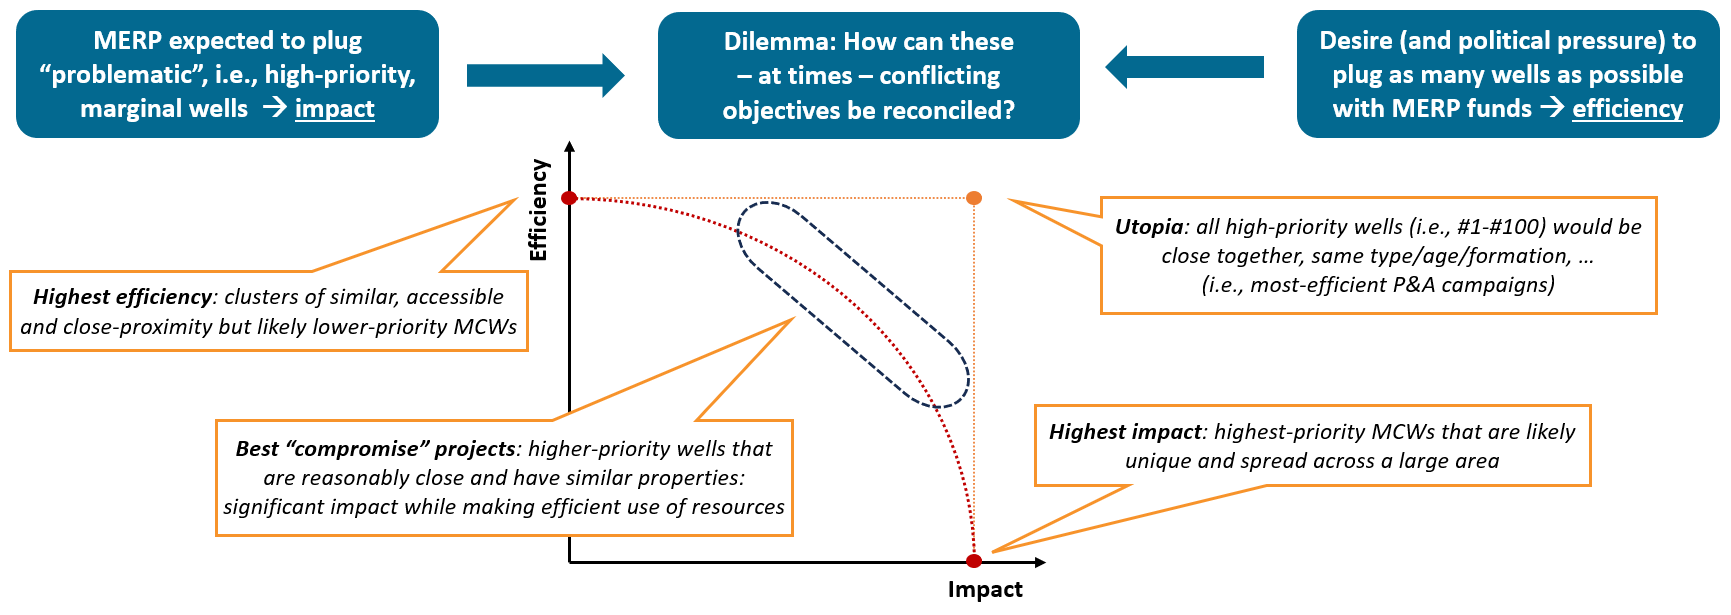

### State-Wide Program Constraints

In [15]:
max_wells_per_owner = 1  #
threshold_distance = 10  # [in miles]
total_budget = 7.5e6     # USD

# Mobilization cost: Assumed to be same for both gas and oil wells
max_num_wells = max([len(gas_wells.data), len(oil_wells.data)])
mobilization_cost = {1: 120000, 2: 210000, 3: 280000, 4: 350000}
for n_wells in range(5, max_num_wells + 1):
    mobilization_cost[n_wells] = n_wells * 84000

# Split the total budget proportionately between gas and oil wells
gas_budget = total_budget * (
    # Fraction of gas wells in the dataset
    len(gas_wells.data) / (len(oil_wells.data) + len(gas_wells.data))
)
oil_budget = total_budget * (
    # Fraction of oil wells in the dataset
    len(oil_wells.data) / (len(oil_wells.data) + len(gas_wells.data))
)

# Set inputs for the optimization models
gas_model_inputs = OptModelInputs(
    well_data=gas_wells,
    total_budget=gas_budget,
    mobilization_cost=mobilization_cost,
    threshold_distance=threshold_distance,
    max_wells_per_owner=max_wells_per_owner,
    objective_weight_impact=100,
)

oil_model_inputs = OptModelInputs(
    well_data=oil_wells,
    total_budget=oil_budget,
    mobilization_cost=mobilization_cost,
    threshold_distance=threshold_distance,
    max_wells_per_owner=max_wells_per_owner,
    objective_weight_impact=100,
)

primo: INFO: Processing optimization model inputs.
primo: INFO: Clustering Data in OptModelInputs
primo: INFO: Finished processing optimization model inputs.
primo: INFO: Processing optimization model inputs.
primo: INFO: Clustering Data in OptModelInputs
primo: INFO: Finished processing optimization model inputs.


### Clustering Wells to Identify High-Impact, High-Efficiency P&A Candidate Projects
At present, wells are clustered based on proximity and similarity in characteristics (e.g. well age) so they can be organized into IMPACTFUL and EFFICIENT P&A projects. To identify groups of wells that would form a promising set for a project, we apply a constrained clustering algorithm.

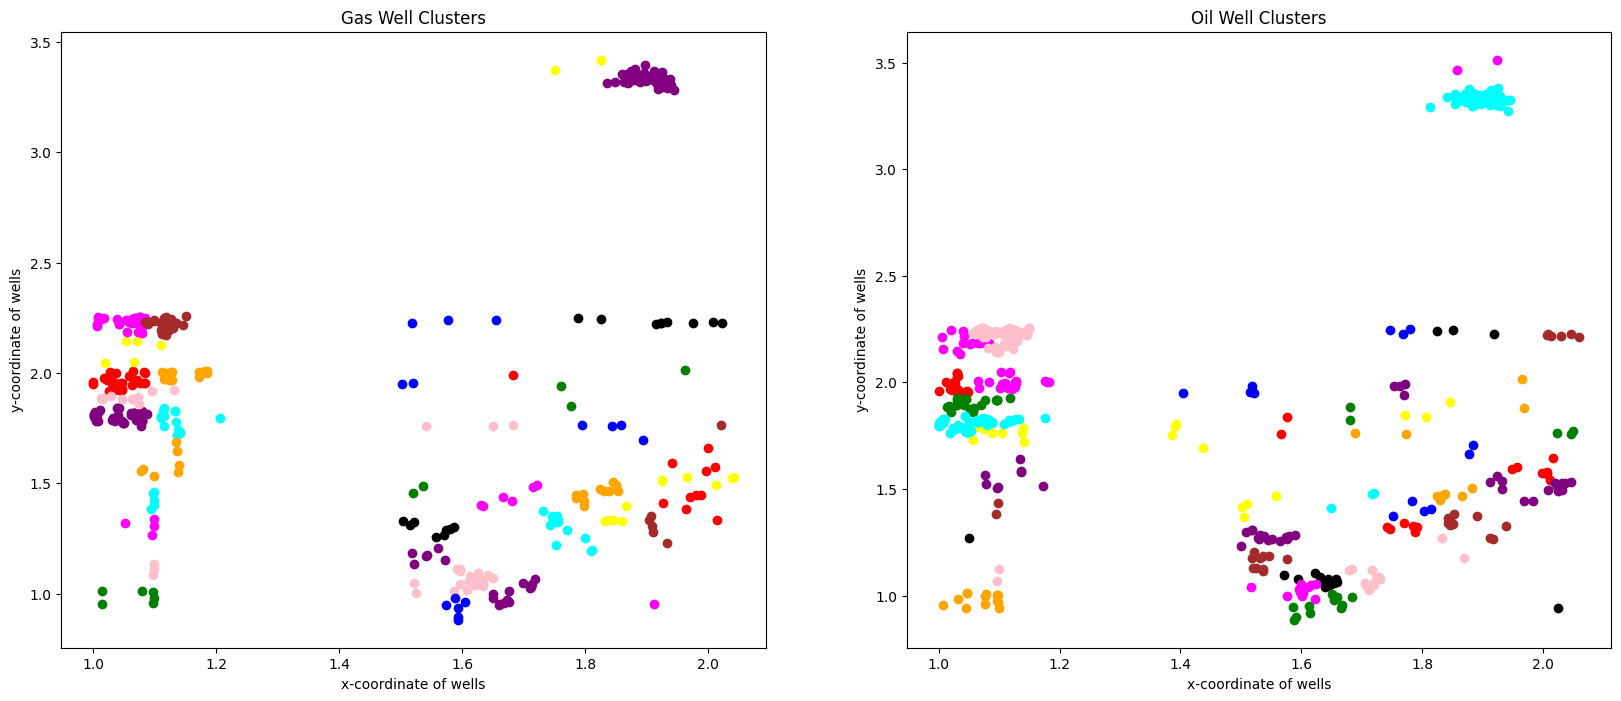

In [16]:
# Use the oil_gdf and gas_gdf pointers defined above
cluster_col_name = "Clusters"

color_list_oil = get_cluster_colors(pd.unique(oil_wells[cluster_col_name]))
color_list_gas = get_cluster_colors(pd.unique(gas_wells[cluster_col_name]))

# Scatter plot of clusters
cluster_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for cluster in color_list_gas:
    gas_cluster = gas_wells[gas_wells[cluster_col_name] == cluster]
    ax1.scatter(
        gas_cluster[col_names.longitude],
        gas_cluster[col_names.latitude],
        c=color_list_gas[cluster],
    )

ax1.set_title('Gas Well Clusters')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')

for cluster in color_list_oil:
    oil_cluster = oil_wells[oil_wells[cluster_col_name] == cluster]
    ax2.scatter(
        oil_cluster[col_names.longitude],
        oil_cluster[col_names.latitude],
        c=color_list_oil[cluster],
    )

ax2.set_title('Oil Well Clusters')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Optimizing for P&A Gas Projects 

In [17]:
gas_model_inputs.build_optimization_model()
opt_campaign_gas = gas_model_inputs.solve_model(solver="highs")

primo: INFO: Beginning to construct the optimization model.
primo: INFO: Completed the construction of the optimization model.
Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 5e+01]
  Cost   [2e+01, 8e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+00]
Presolving model
285 rows, 967 cols, 2243 nonzeros  0s
203 rows, 842 cols, 1951 nonzeros  0s
203 rows, 840 cols, 2569 nonzeros  0s

Solving MIP model with:
   203 rows
   840 cols (839 binary, 0 integer, 1 implied int., 0 continuous)
   2569 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   11853.897256    -inf                 inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   2595.4109

### Optimizing for P&A Oil Projects

In [18]:
oil_model_inputs.build_optimization_model()
opt_campaign_oil = oil_model_inputs.solve_model(solver="highs")

primo: INFO: Beginning to construct the optimization model.
primo: INFO: Completed the construction of the optimization model.
Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+02]
  Cost   [2e+01, 8e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+00]
Presolving model
332 rows, 1269 cols, 3002 nonzeros  0s
243 rows, 1044 cols, 2448 nonzeros  0s
243 rows, 1038 cols, 3016 nonzeros  0s

Solving MIP model with:
   243 rows
   1038 cols (1037 binary, 0 integer, 1 implied int., 0 continuous)
   3016 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   13337.475244    -inf                 inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   3433

### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Gas Projects

In [19]:
opt_campaign_gas.set_efficiency_weights(eff_metrics)
opt_campaign_gas.compute_efficiency_scores()

primo: INFO: Computing overall efficiency score for project 1
primo: INFO: Computing overall efficiency score for project 11
primo: INFO: Computing overall efficiency score for project 13
primo: INFO: Computing overall efficiency score for project 19


In [20]:
#results for optimal projects for gas
print(opt_campaign_gas)

The optimal campaign has 4 projects.
The total cost of the campaign is $3,206,000

Number of wells in project 1		: 22
Estimated Project Cost			: $1,848,000
Impact Score [0-100]			: 68.87
Efficiency Score [0-100]		: 32.23

Number of wells in project 11		: 7
Estimated Project Cost			: $588,000
Impact Score [0-100]			: 65.61
Efficiency Score [0-100]		: 48.97

Number of wells in project 13		: 4
Estimated Project Cost			: $350,000
Impact Score [0-100]			: 64.01
Efficiency Score [0-100]		: 48.16

Number of wells in project 19		: 5
Estimated Project Cost			: $420,000
Impact Score [0-100]			: 64.80
Efficiency Score [0-100]		: 49.31




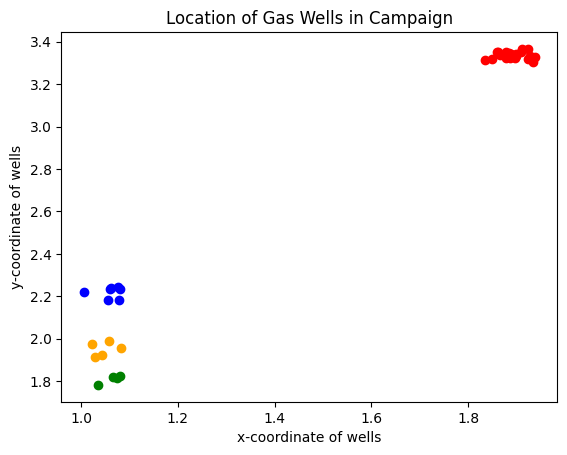

In [21]:
opt_campaign_gas.plot_campaign(title="Location of Gas Wells in Campaign")

In [22]:
# display the information for each project
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with EFFICIENCY SCORE : {opt_campaign_gas.get_efficiency_score_project(project_id):.2f} and IMPACT SCORE : {opt_campaign_gas.get_impact_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with EFFICIENCY SCORE : 32.23 and IMPACT SCORE : 68.87'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
789,48446,Owner 126,3.33,1.93,86,65,67.06
807,69687,Owner 7,3.32,1.85,100,1918,63.98
812,84538,Owner 94,3.32,1.92,110,10140,68.82
817,23065,Owner 200,3.30,1.93,113,11419,67.11
829,84290,Owner 2,3.33,1.94,84,2261,70.03
833,91176,Owner 85,3.34,1.87,97,3609,68.28
841,11428,Owner 147,3.32,1.90,92,4007,65.83
843,97876,Owner 183,3.33,1.90,111,10459,69.67
844,47058,Owner 74,3.34,1.90,62,8604,67.11
849,82654,Owner 185,3.34,1.90,94,243,65.35


'Well information for Project 11 with EFFICIENCY SCORE : 48.97 and IMPACT SCORE : 65.61'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
101,62199,Owner 246,2.18,1.05,125,8108,64.71
108,52884,Owner 115,2.18,1.08,122,4595,65.53
118,79899,Owner 29,2.22,1.01,116,1766,66.81
180,57844,Owner 66,2.23,1.08,150,1140,67.65
272,10241,Owner 188,2.23,1.06,104,1794,65.29
274,37637,Owner 59,2.24,1.06,90,6487,65.10
397,84951,Owner 240,2.24,1.08,148,7900,64.16


'Well information for Project 13 with EFFICIENCY SCORE : 48.16 and IMPACT SCORE : 64.01'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
49,16079,Owner 120,1.78,1.04,76,10119,62.84
67,50038,Owner 117,1.83,1.08,83,5892,69.64
88,46413,Owner 51,1.82,1.07,142,111,62.30
210,13528,Owner 107,1.82,1.07,142,7216,61.28


'Well information for Project 19 with EFFICIENCY SCORE : 49.31 and IMPACT SCORE : 64.80'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
21,86095,Owner 65,1.96,1.08,19,2604,69.50
83,28188,Owner 157,1.92,1.03,125,5948,66.80
182,68237,Owner 6,1.92,1.04,126,3965,61.62
280,73758,Owner 169,1.97,1.02,150,7053,63.95
981,69512,Owner 104,1.99,1.06,123,7277,62.11


### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Oil Projects

In [23]:
opt_campaign_oil.set_efficiency_weights(eff_metrics)
opt_campaign_oil.compute_efficiency_scores()

primo: INFO: Computing overall efficiency score for project 1
primo: INFO: Computing overall efficiency score for project 5
primo: INFO: Computing overall efficiency score for project 34
primo: INFO: Computing overall efficiency score for project 35


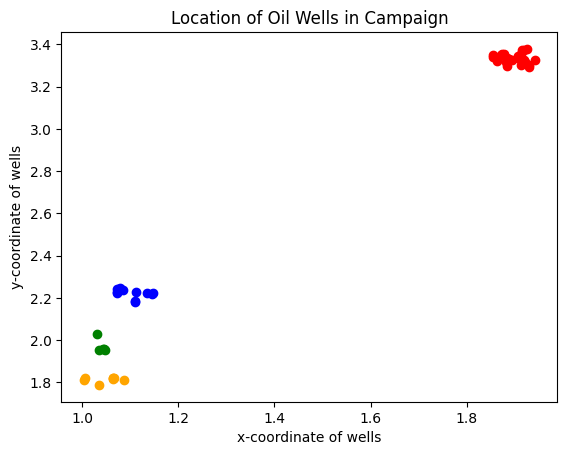

In [24]:
opt_campaign_oil.plot_campaign(title="Location of Oil Wells in Campaign")

In [25]:
for project_id, project_data in opt_campaign_oil.get_project_well_information().items():
    display(f"Well information for Project {project_id} with EFFICIENCY SCORE : {opt_campaign_oil.get_efficiency_score_project(project_id):.2f} and IMPACT SCORE : {opt_campaign_oil.get_impact_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with EFFICIENCY SCORE : 32.28 and IMPACT SCORE : 67.05'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
788,94951,Owner 202,3.30,1.91,114,730,65.23
791,73934,Owner 127,3.33,1.91,109,11289,65.53
797,65431,Owner 177,3.33,1.91,123,9596,66.17
798,85318,Owner 102,3.33,1.89,98,9605,71.67
803,85997,Owner 160,3.32,1.92,112,9879,64.72
816,79728,Owner 213,3.31,1.93,108,6747,64.62
819,27016,Owner 108,3.31,1.88,47,1191,74.79
825,87307,Owner 68,3.29,1.93,96,4886,65.16
828,67212,Owner 101,3.33,1.94,136,2536,70.01
830,33872,Owner 61,3.33,1.92,78,12325,66.85


'Well information for Project 5 with EFFICIENCY SCORE : 48.33 and IMPACT SCORE : 66.80'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
216,74117,Owner 187,2.23,1.07,130,10319,64.53
390,27532,Owner 85,2.25,1.08,124,6631,64.89
411,71547,Owner 209,2.23,1.07,128,2610,63.84
706,80939,Owner 21,2.24,1.08,143,4989,65.87
776,44388,Owner 137,2.22,1.13,139,11323,73.37
781,22370,Owner 194,2.22,1.15,144,4565,74.37
784,62214,Owner 117,2.22,1.14,136,2192,66.80
968,16671,Owner 18,2.18,1.11,143,7823,65.94
969,59562,Owner 178,2.18,1.11,106,4429,64.60
979,53671,Owner 99,2.23,1.11,141,3092,65.11


'Well information for Project 34 with EFFICIENCY SCORE : 45.00 and IMPACT SCORE : 65.63'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
10,47811,Owner 130,1.96,1.05,74,11119,65.25
11,71173,Owner 120,1.96,1.05,143,10805,63.70
13,85330,Owner 129,1.96,1.04,141,8764,66.97
24,28545,Owner 145,1.95,1.04,149,7290,64.14
263,89373,Owner 95,2.03,1.03,150,226,68.12


'Well information for Project 35 with EFFICIENCY SCORE : 44.15 and IMPACT SCORE : 67.25'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
163,21133,Owner 53,1.82,1.06,148,4199,75.01
171,68291,Owner 176,1.82,1.06,107,12598,65.60
188,83353,Owner 1,1.82,1.07,132,8906,68.18
288,32138,Owner 20,1.81,1.00,128,4531,66.90
311,97973,Owner 168,1.82,1.01,147,6845,66.92
321,80587,Owner 186,1.79,1.04,140,11333,64.14
992,32031,Owner 78,1.82,1.06,132,1563,67.23
999,99999,Owner 84,1.81,1.09,103,6957,64.04


### Manual overrides for existing projects

PRIMO allows users to modify projects manually to satisfy requirements not considered above.

Please use the widgets to select the projects and/or wells:
- Step 1 - Remove Widget: This widget allows you to remove projects and/or wells from the recommended P&A projects.
    - Select P&A projects that should be removed from the recommendations. To confirm your selection, press the "Select Projects to Manually Remove" button. 
    - Select wells that should be removed from the recommended P&A projects. To confirm your selection, press the "Select Wells to Manually Remove" button. 
    - Once you are satisfied with your selections, please press the "Confirm Removal" button to proceed to the next step.
- Step 2 - Add Widget: Use this widget to select wells to be included in the P&A projects. 
    - Select wells using the text box on the left and enter the project in which the well should be included using the text box on the right. If you do not wish to include the well in a specific project, please leave the project text box with its default value, which will appear when you select the well on the left. To confirm your selection, press the "Select Wells to Manually Add" button.
- Step 3 - Lock Widget: his widget is for locking wells and/or projects in the recommended P&A projects during the re-optimization step.
    - Select P&A projects that you are satisfied with and wish to keep. To confirm your selection, press the "Select Projects to Manually Lock" button. 
    - Select wells that should be retained in the recommended P&A projects. To confirm your selection, press the "Select Wells to Manually Lock" button.

Notice:
- If you need to exclude a project or well that has already been selected, please use the "Undo" button associated with the corresponding widget.
- Once you click the "Confirm Removal" button, you will not be able to modify the projects and wells selected for removal. Please re-execute the cell below to restart your selection.
- If you do not want to remove, add, or lock any projects or wells, please leave the corresponding widget blank.
- Selections must be made for each type of well project individually.

#### Gas wells

##### Select wells to be included in or excluded from the Recommended P&A Projects 

In [26]:
override_widget_gas = UserSelection(opt_campaign_gas.clusters_dict,gas_model_inputs)
override_widget_gas.display()

'Remove projects/wells'

##### Results based on the User-input Override Lists

In [27]:
override_selections_gas = override_widget_gas.return_value()
campaign_gas = OverrideCampaign(override_selections_gas,gas_model_inputs,opt_campaign_gas.clusters_dict,eff_metrics)
violation_info_dict_gas = campaign_gas.violation_info()
for msg,df in violation_info_dict_gas.items():
    display(Markdown(msg),df)
logging.disable(logging.INFO)
override_campaign_gas = campaign_gas.recalculate()
print(override_campaign_gas)
logging.disable(logging.NOTSET)
logging.basicConfig(level=logging.INFO)

Project Status:

'FEASIBLE'

The optimal campaign has 4 projects.
The total cost of the campaign is $3,206,000

Number of wells in project 1		: 22
Estimated Project Cost			: $1,848,000
Impact Score [0-100]			: 68.87
Efficiency Score [0-100]		: 32.23

Number of wells in project 11		: 7
Estimated Project Cost			: $588,000
Impact Score [0-100]			: 65.61
Efficiency Score [0-100]		: 48.97

Number of wells in project 13		: 4
Estimated Project Cost			: $350,000
Impact Score [0-100]			: 64.01
Efficiency Score [0-100]		: 48.16

Number of wells in project 19		: 5
Estimated Project Cost			: $420,000
Impact Score [0-100]			: 64.80
Efficiency Score [0-100]		: 49.31




##### Re-optimize

Users have the option to re-run the optimization problem in PRIMO, generating new P&A projects based on the previously selected overrides.

In [28]:
override_dict_gas = campaign_gas.re_optimize_dict()
gas_model_inputs.update_cluster(override_selections_gas.add_widget_return)
gas_model_inputs.build_optimization_model(override_dict_gas)
opt_campaign_gas = gas_model_inputs.solve_model(solver="highs")
opt_campaign_gas.set_efficiency_weights(eff_metrics)
opt_campaign_gas.compute_efficiency_scores()
print(opt_campaign_gas)

primo: INFO: Beginning to construct the optimization model.
primo: INFO: Completed the construction of the optimization model.
Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 5e+01]
  Cost   [2e+01, 8e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+00]
Presolving model
285 rows, 967 cols, 2243 nonzeros  0s
203 rows, 842 cols, 1951 nonzeros  0s
203 rows, 840 cols, 2569 nonzeros  0s

Solving MIP model with:
   203 rows
   840 cols (839 binary, 0 integer, 1 implied int., 0 continuous)
   2569 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   11853.897256    -inf                 inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   2595.4109

In [29]:
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with EFFICIENCY SCORE : {opt_campaign_gas.get_efficiency_score_project(project_id):.2f} and IMPACT SCORE : {opt_campaign_gas.get_impact_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with EFFICIENCY SCORE : 32.23 and IMPACT SCORE : 68.87'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
789,48446,Owner 126,3.33,1.93,86,65,67.06
807,69687,Owner 7,3.32,1.85,100,1918,63.98
812,84538,Owner 94,3.32,1.92,110,10140,68.82
817,23065,Owner 200,3.30,1.93,113,11419,67.11
829,84290,Owner 2,3.33,1.94,84,2261,70.03
833,91176,Owner 85,3.34,1.87,97,3609,68.28
841,11428,Owner 147,3.32,1.90,92,4007,65.83
843,97876,Owner 183,3.33,1.90,111,10459,69.67
844,47058,Owner 74,3.34,1.90,62,8604,67.11
849,82654,Owner 185,3.34,1.90,94,243,65.35


'Well information for Project 11 with EFFICIENCY SCORE : 48.97 and IMPACT SCORE : 65.61'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
101,62199,Owner 246,2.18,1.05,125,8108,64.71
108,52884,Owner 115,2.18,1.08,122,4595,65.53
118,79899,Owner 29,2.22,1.01,116,1766,66.81
180,57844,Owner 66,2.23,1.08,150,1140,67.65
272,10241,Owner 188,2.23,1.06,104,1794,65.29
274,37637,Owner 59,2.24,1.06,90,6487,65.10
397,84951,Owner 240,2.24,1.08,148,7900,64.16


'Well information for Project 13 with EFFICIENCY SCORE : 48.16 and IMPACT SCORE : 64.01'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
49,16079,Owner 120,1.78,1.04,76,10119,62.84
67,50038,Owner 117,1.83,1.08,83,5892,69.64
88,46413,Owner 51,1.82,1.07,142,111,62.30
210,13528,Owner 107,1.82,1.07,142,7216,61.28


'Well information for Project 19 with EFFICIENCY SCORE : 49.31 and IMPACT SCORE : 64.80'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
21,86095,Owner 65,1.96,1.08,19,2604,69.50
83,28188,Owner 157,1.92,1.03,125,5948,66.80
182,68237,Owner 6,1.92,1.04,126,3965,61.62
280,73758,Owner 169,1.97,1.02,150,7053,63.95
981,69512,Owner 104,1.99,1.06,123,7277,62.11


If necessary, please execute the cell to generate the widgets and make a new override selection based on the re-optimized recommended P&A projects.

#### Oil wells

##### Select wells to be included in or excluded from the Recommended P&A Projects 

In [30]:
override_widget_oil = UserSelection(opt_campaign_oil.clusters_dict,oil_model_inputs)
override_widget_oil.display()

'Remove projects/wells'

##### Results based on the User-input Override Lists

In [31]:
override_selections_oil = override_widget_oil.return_value()
campaign_oil = OverrideCampaign(override_selections_oil,oil_model_inputs,opt_campaign_oil.clusters_dict,eff_metrics)
violation_info_dict_oil = campaign_oil.violation_info()
for msg,df in violation_info_dict_oil.items():
    display(Markdown(msg),df)
logging.disable(logging.INFO)
override_campaign_oil = campaign_oil.recalculate()
print(override_campaign_oil)
logging.disable(logging.NOTSET)
logging.basicConfig(level=logging.INFO)

Project Status:

'FEASIBLE'

The optimal campaign has 4 projects.
The total cost of the campaign is $4,284,000

Number of wells in project 1		: 27
Estimated Project Cost			: $2,268,000
Impact Score [0-100]			: 67.05
Efficiency Score [0-100]		: 32.28

Number of wells in project 5		: 11
Estimated Project Cost			: $924,000
Impact Score [0-100]			: 66.80
Efficiency Score [0-100]		: 48.33

Number of wells in project 34		: 5
Estimated Project Cost			: $420,000
Impact Score [0-100]			: 65.63
Efficiency Score [0-100]		: 45.00

Number of wells in project 35		: 8
Estimated Project Cost			: $672,000
Impact Score [0-100]			: 67.25
Efficiency Score [0-100]		: 44.15




##### Re-optimize

Users have the option to re-run the optimization problem in PRIMO, generating new P&A projects based on the previously selected overrides.

In [32]:
override_dict_oil = campaign_oil.re_optimize_dict()
oil_model_inputs.update_cluster(override_selections_oil.add_widget_return)
oil_model_inputs.build_optimization_model(override_dict_oil)
opt_campaign_oil = oil_model_inputs.solve_model(solver="highs")
opt_campaign_oil.set_efficiency_weights(eff_metrics)
opt_campaign_oil.compute_efficiency_scores()
print(opt_campaign_oil)

primo: INFO: Beginning to construct the optimization model.
primo: INFO: Completed the construction of the optimization model.
Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+02]
  Cost   [2e+01, 8e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+00]
Presolving model
332 rows, 1269 cols, 3002 nonzeros  0s
243 rows, 1044 cols, 2448 nonzeros  0s
243 rows, 1038 cols, 3016 nonzeros  0s

Solving MIP model with:
   243 rows
   1038 cols (1037 binary, 0 integer, 1 implied int., 0 continuous)
   3016 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   13337.475244    -inf                 inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   3433

In [33]:
for project_id, project_data in opt_campaign_oil.get_project_well_information().items():
    display(f"Well information for Project {project_id} with EFFICIENCY SCORE : {opt_campaign_oil.get_efficiency_score_project(project_id):.2f} and IMPACT SCORE : {opt_campaign_oil.get_impact_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with EFFICIENCY SCORE : 32.28 and IMPACT SCORE : 67.05'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
788,94951,Owner 202,3.30,1.91,114,730,65.23
791,73934,Owner 127,3.33,1.91,109,11289,65.53
797,65431,Owner 177,3.33,1.91,123,9596,66.17
798,85318,Owner 102,3.33,1.89,98,9605,71.67
803,85997,Owner 160,3.32,1.92,112,9879,64.72
816,79728,Owner 213,3.31,1.93,108,6747,64.62
819,27016,Owner 108,3.31,1.88,47,1191,74.79
825,87307,Owner 68,3.29,1.93,96,4886,65.16
828,67212,Owner 101,3.33,1.94,136,2536,70.01
830,33872,Owner 61,3.33,1.92,78,12325,66.85


'Well information for Project 5 with EFFICIENCY SCORE : 48.33 and IMPACT SCORE : 66.80'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
216,74117,Owner 187,2.23,1.07,130,10319,64.53
390,27532,Owner 85,2.25,1.08,124,6631,64.89
411,71547,Owner 209,2.23,1.07,128,2610,63.84
706,80939,Owner 21,2.24,1.08,143,4989,65.87
776,44388,Owner 137,2.22,1.13,139,11323,73.37
781,22370,Owner 194,2.22,1.15,144,4565,74.37
784,62214,Owner 117,2.22,1.14,136,2192,66.80
968,16671,Owner 18,2.18,1.11,143,7823,65.94
969,59562,Owner 178,2.18,1.11,106,4429,64.60
979,53671,Owner 99,2.23,1.11,141,3092,65.11


'Well information for Project 34 with EFFICIENCY SCORE : 45.00 and IMPACT SCORE : 65.63'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
10,47811,Owner 130,1.96,1.05,74,11119,65.25
11,71173,Owner 120,1.96,1.05,143,10805,63.70
13,85330,Owner 129,1.96,1.04,141,8764,66.97
24,28545,Owner 145,1.95,1.04,149,7290,64.14
263,89373,Owner 95,2.03,1.03,150,226,68.12


'Well information for Project 35 with EFFICIENCY SCORE : 44.15 and IMPACT SCORE : 67.25'

,API Well Number,Operator Name,y,x,Age [Years],Depth [ft],Priority Score [0-100]
163,21133,Owner 53,1.82,1.06,148,4199,75.01
171,68291,Owner 176,1.82,1.06,107,12598,65.60
188,83353,Owner 1,1.82,1.07,132,8906,68.18
288,32138,Owner 20,1.81,1.00,128,4531,66.90
311,97973,Owner 168,1.82,1.01,147,6845,66.92
321,80587,Owner 186,1.79,1.04,140,11333,64.14
992,32031,Owner 78,1.82,1.06,132,1563,67.23
999,99999,Owner 84,1.81,1.09,103,6957,64.04


If necessary, please execute the cell to generate the widgets and make a new override selection based on the re-optimized recommended P&A projects.

#### Export Results

In [34]:
output_file_path = "Override_Projects.xlsx"
campaigns = [override_campaign_gas,override_campaign_oil]
campaign_labels = ["Gas","Oil"]
export_data_to_excel(output_file_path, campaigns, campaign_labels)

# Capability 3: P&A Project Efficiency Assessments
Ideal P&A projects not only include (many) high-priority wells but also prioritize the efficient use of available resources (e.g., budget, crews, equipment, ...). PRIMO has been designed to quantify the expected IMPACT and EFFICIENCY of recommended P&A candidate projects.

We employ a series of user-defined functions to calculate essential KPIs for each proposed P&A project.

- **Number of Wells**: The more wells a P&A project includes, the the more efficient plugging operations are expected to be - especially if the respective wells are close to each other. Note that upper limits on the number of wells per project may be imposed. Counted as the total number of wells associated with each project.

- **Well Proximities**: This KPI quantifies the "compactness" of any given P&A project. Wells close to each other lead to efficient plugging projects (e.g., reduced mobilization costs/efforts). Defined as the average absolute distance from well locations to the centroid of the project cluster.

- **Well Accessibility - Road Access**: The distance of any well to the closest road access point is used as a measure of well accessibility. The further a well is from any established road, the most costly it is presumed the P&A operation will be. Road construction cost can be significant contributor to project costs and efforts. Measured as the average absolute distance from well locations to their nearest road point. 

- **Well Accessibility - Elevation Change**: This KPI attempts to assess the accessibility of wells by comparing the elevation of the closest road access points to the elevation of the wells contained in a P&A project. If multiple wells in a project are characterized by significant elevation changes, they are presumed to be less accessible which increases P&A costs leading to inefficiencies. Computed as the average absolute elevation delta across all wells within the project group. The elevation delta is referred as the difference in surface elevation of the well and the elevation of the closest road access point. 

- **Well Characteristics - Age Range**: Wells with similar characteristics make for efficient P&A projects. As such, significant differences in well ages within a P&A project can pose challenges to P&A operations. The closer wells are in terms of age, the more efficient a P&A project is presumed to be. This metric Determined by subtracting the minimum age from the maximum age of wells within each P&A project. 

- **Well Characteristics - Depth Range**: Significant differences in well depths within a P&A project can pose challenges to P&A operations. The closer the wells are in terms of depth, the more efficient a P&A project is presumed to be. Calculated as the difference between the maximum and minimum depths of wells within the cluster. 

- **Number of Unique Well Owners**: As the number of (unique) well owners included in a given P&A project increases, so does the effort to manage a given project. Captured by counting the number of distinct company names associated with wells within each project. 

Upon computation of the KPIs for each P&A project, the next step is to scale these raw KPI values into standardized scores between 0 - 100 and then take the weighted average to calculate the **Efficiency Score** of the projects. 

## Efficiency Metrics for P&A Gas Projects

We calculate selected efficiency metrics for each plugging project:

In [35]:
display(opt_campaign_gas.get_efficiency_metrics())

,Project ID,Age Range Score [0-10],Depth Range Score [0-20],Elevation Delta Score [0-20],Num Unique Owners Score [0-30],Num Wells Score [0-20],Accessibility Score [0-20],Efficiency Score [0-100]
0,1,4.50,0.15,7.58,0.00,20.00,7.58,32.23
1,11,6.04,9.20,6.59,21.43,5.71,6.59,48.97
2,13,5.64,4.47,9.48,25.71,2.86,9.48,48.16
3,19,1.28,12.77,7.17,24.29,3.81,7.17,49.31


Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the gas plugging projects are shown below:

In [36]:
display(opt_campaign_gas.get_campaign_summary())

,Project ID,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
0,1,22,68.87,32.23
1,11,7,65.61,48.97
2,13,4,64.01,48.16
3,19,5,64.80,49.31


## Efficiency Metrics for P&A Oil Projects

We calculate selected efficiency metrics for each plugging project:

In [37]:
display(opt_campaign_oil.get_efficiency_metrics())

,Project ID,Age Range Score [0-10],Depth Range Score [0-20],Elevation Delta Score [0-20],Num Unique Owners Score [0-30],Num Wells Score [0-20],Accessibility Score [0-20],Efficiency Score [0-100]
0,1,3.02,1.32,7.94,0.00,20.00,7.94,32.28
1,5,7.52,5.96,8.70,18.46,7.69,8.70,48.33
2,34,4.97,3.25,8.32,25.38,3.08,8.32,45.00
3,35,7.05,3.03,6.77,21.92,5.38,6.77,44.15


Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the oil plugging projects are shown below:

In [38]:
display(opt_campaign_oil.get_campaign_summary())

,Project ID,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
0,1,27,67.05,32.28
1,5,11,66.80,48.33
2,34,5,65.63,45.00
3,35,8,67.25,44.15


## Saving PRIMO Results

We save the gas well and oil well projects in an excel file for each run. The default file name for the run is "Primo_Projects.xlsx".

In [39]:
output_file_path = "Primo_Projects.xlsx"
campaigns = [opt_campaign_gas, opt_campaign_oil]
campaign_labels = ["Gas", "Oil"]
export_data_to_excel(output_file_path, campaigns, campaign_labels)